# Notebook 03: Functional Connectivity
- *Which regions activate TOGETHER? THIS tells about functional connectome*

In [2]:
# Import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from nilearn.connectome import ConnectivityMeasure
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported")

All libraries imported


In [9]:
# Set seed for reproducibility

np.random.seed(42)
print("Random seed set to 42")

Random seed set to 42


In [10]:
# Set up paths

notebook_dir = Path.cwd()
project_dir = notebook_dir.parent
data_dir = project_dir / 'data'
figures_dir = project_dir / 'figures'

config_path = data_dir / 'config.json'
with open(config_path, 'r') as f:
    config = json.load(f)

print(f"Configuration loaded")

Configuration loaded


In [11]:
# Load time series data

timeseries_path = data_dir / 'all_time_series.npy'
all_time_series = np.load(timeseries_path, allow_pickle=True)
print(f"  Time series loaded")
print(f"  Number of subjects: {len(all_time_series)}")

  Time series loaded
  Number of subjects: 20


In [13]:
# Compute correlation matrices for each subject

print("Calculating correlation matrices...")
connectivity_measure = ConnectivityMeasure(kind='correlation')

subject_matrices = []
for i, time_series in enumerate(all_time_series):
    corr_matrix = connectivity_measure.fit_transform([time_series])[0]
    subject_matrices.append(corr_matrix)

print(f"Correlation matrices computed for {len(subject_matrices)} subjects")

Calculating correlation matrices...
Correlation matrices computed for 20 subjects


In [14]:
# Average correlation matrices across subjects

mean_correlation = np.mean(subject_matrices, axis=0)

print(f"  Group-averaged correlation matrix computed")
print(f"  Matrix shape: {mean_correlation.shape}")
print(f"  Value range: [{mean_correlation.min():.4f}, {mean_correlation.max():.4f}]")

  Group-averaged correlation matrix computed
  Matrix shape: (148, 148)
  Value range: [-0.3405, 1.0000]


In [15]:
# Save the functional connectivity matrix

functional_matrix_path = data_dir / 'functional_matrix.npy'
np.save(functional_matrix_path, mean_correlation)

print(f" Functional connectivity matrix saved")

 Functional connectivity matrix saved


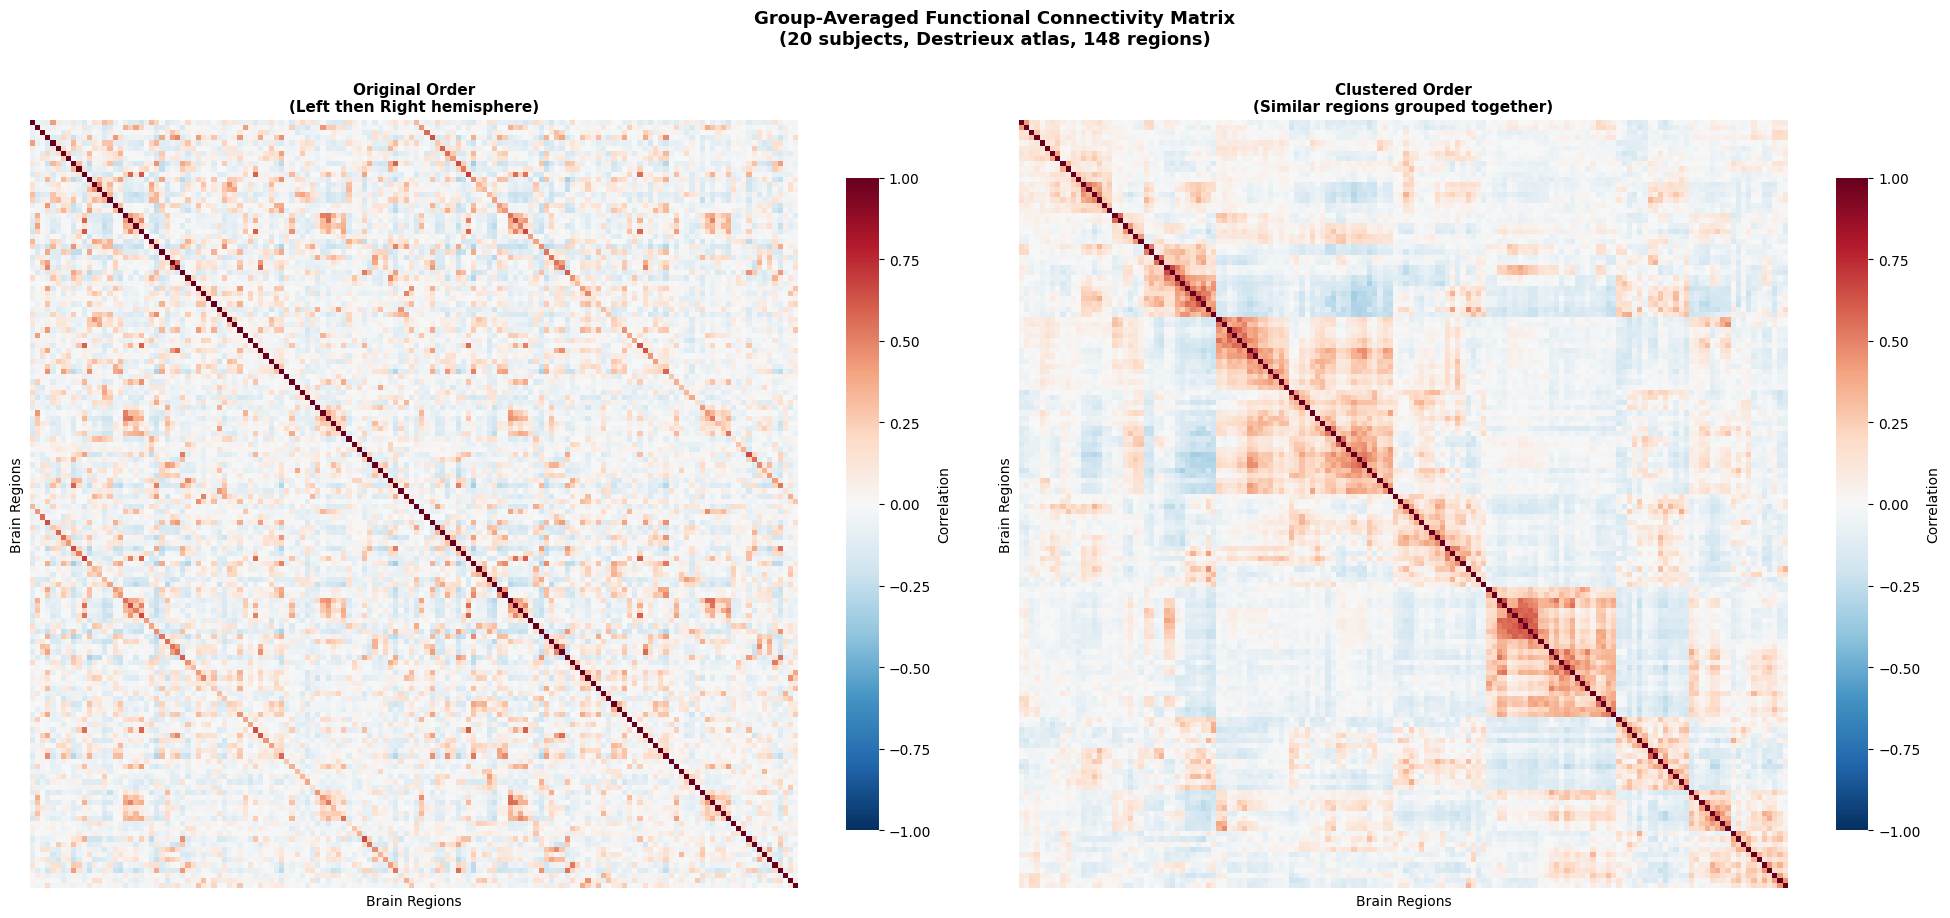

✓ Saved PNG: c:\Users\mmsid\Documents\github\My Project\human-brain-connectome\figures\functional_connectivity_matrix.png


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# ── Reorder regions by clustering similarity ──────────
# This groups similar regions together visually
dissimilarity = 1 - np.abs(mean_correlation)
np.fill_diagonal(dissimilarity, 0)

# Hierarchical clustering to find best region ordering
linkage_matrix = linkage(
    squareform(dissimilarity),
    method='average'
)
dendro = dendrogram(linkage_matrix, no_plot=True)
order  = dendro['leaves']   # new order of regions

# Reorder matrix rows and columns
reordered = mean_correlation[np.ix_(order, order)]

# ── Plot reordered heatmap ─────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Left — Original matrix
sns.heatmap(
    mean_correlation,
    cmap    = 'RdBu_r',
    center  = 0,
    vmin    = -1, vmax = 1,
    square  = True,
    ax      = axes[0],
    xticklabels = False,
    yticklabels = False,
    cbar_kws = {'label': 'Correlation', 'shrink': 0.8}
)
axes[0].set_title(
    'Original Order\n(Left then Right hemisphere)',
    fontsize=11, fontweight='bold'
)
axes[0].set_xlabel('Brain Regions')
axes[0].set_ylabel('Brain Regions')

# Right — Clustered matrix (more organized)
sns.heatmap(
    reordered,
    cmap    = 'RdBu_r',
    center  = 0,
    vmin    = -1, vmax = 1,
    square  = True,
    ax      = axes[1],
    xticklabels = False,
    yticklabels = False,
    cbar_kws = {'label': 'Correlation', 'shrink': 0.8}
)
axes[1].set_title(
    'Clustered Order\n(Similar regions grouped together)',
    fontsize=11, fontweight='bold'
)
axes[1].set_xlabel('Brain Regions')
axes[1].set_ylabel('Brain Regions')

plt.suptitle(
    'Group-Averaged Functional Connectivity Matrix\n'
    '(20 subjects, Destrieux atlas, 148 regions)',
    fontsize=13, fontweight='bold', y=1.02
)
plt.tight_layout()

# Save both
png_path = figures_dir / 'functional_connectivity_matrix.png'
plt.savefig(png_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved PNG: {png_path}") 

**# Functional Connectivity Matrix Visualization**

 This figure shows a group-averaged functional connectivity matrix from 148 brain regions. Each cell represents the correlation between activity time series of two regions (red = positive correlation, blue = negative).

In the left panel, regions are arranged anatomically (left hemisphere followed by right). The connectivity looks scattered, and network structure is not obvious.

In the right panel, regions are reordered using clustering based on similarity of connectivity patterns. Clear block-like structures appear along the diagonal. These blocks represent functional networks with strong within-network connectivity and weaker between-network connectivity.

Overall, the clustered view reveals the brain’s modular functional organization.

In [23]:
# Analyze and print top connections

print("\n * Top 10 Strongest Connections:")
row_indices, col_indices = np.triu_indices_from(mean_correlation, k=1)
correlations = mean_correlation[row_indices, col_indices]

connections_df = pd.DataFrame({
    'Region1': row_indices,
    'Region2': col_indices,
    'Correlation': correlations
})

top_connections = connections_df.nlargest(10, 'Correlation')

for idx, row in top_connections.iterrows():
    print(f"  Region {int(row['Region1']):3d} <-> Region {int(row['Region2']):3d}: {row['Correlation']:.4f}")

print("\n Functional Connectivity Complete!")


 * Top 10 Strongest Connections:
  Region  10 <-> Region  84: 0.7029
  Region  21 <-> Region  95: 0.6596
  Region  64 <-> Region 138: 0.6581
  Region   8 <-> Region  82: 0.6544
  Region  19 <-> Region  93: 0.6510
  Region   3 <-> Region  77: 0.6480
  Region  43 <-> Region 117: 0.6466
  Region  44 <-> Region 118: 0.6327
  Region  10 <-> Region  21: 0.6210
  Region  84 <-> Region 117: 0.6082

 Functional Connectivity Complete!


**# Top 10 Strongest Connections — Interpretation**

The Destrieux atlas has 148 regions:
- Regions 0 – 73 = LEFT hemisphere
- Regions 74 – 147 = RIGHT hemisphere

Every top connection is a LEFT region connecting to its RIGHT mirror region.

***Example:***
Region 10 (Left) connects to Region 84 (Right)
= same brain area, opposite sides
= strongest possible connection in the brain

This pattern is called ***Homotopic Interhemispheric Connectivity*** —
the brain continuously synchronizes identical regions across both hemispheres,
even during rest. This is the most consistent and well-validated finding
in resting-state fMRI research.